AIM: To perform intent classification using MLP and integer encoding (TextVectorization Layer).

In [ ]:
# import libraries
from google.colab import drive
import os

import tensorflow as tf
from tensorflow.keras import layers

import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# mount google drive and connect working directory
drive.mount('/content/gdrive', force_remount = True)
print (sorted(os.listdir('gdrive/My Drive/Colab Helper/ICData/Dataset')))
os.chdir('gdrive/My Drive/Colab Helper/ICData/Dataset') # Connect to the directory

Mounted at /content/gdrive
['data_file.csv', 'glove.6B.100d.txt', 'glove.6B.50d.txt', 'model', 'test_.csv', 'train_.csv', 'valid_.csv']


In [ ]:
# read train file and print it's shape
traindf = pd.read_csv('train_.csv', usecols=['text','intent'])
testdf = pd.read_csv('test_.csv', usecols=['text','intent'])
validdf = pd.read_csv('valid_.csv', usecols=['text','intent'])

print('Train Shape: ', traindf.shape)
print('Test Shape: ', testdf.shape)
print('Valid Shape: ', validdf.shape)

Train Shape:  (9951, 2)
Test Shape:  (1280, 2)
Valid Shape:  (2985, 2)


Observation:

1.   No NULL value present.

In [ ]:
# NULL value presence check
print('NULL values: ', traindf['text'].isnull().sum())

NULL values:  0


Observation:

1.   Texts may not require a lot of text cleaning.

In [ ]:
# display first 10 rows
print('First 10 rows:\n', traindf.head(10))

First 10 rows:
                                                 text              intent
0                          find under night in-birth  SearchCreativeWork
1         book a spot in town in the same area as me      BookRestaurant
2                                         fimd glory  SearchCreativeWork
3       i need a restaurant on july 18th in rose bud      BookRestaurant
4  book a spot for 4 in oklahoma at south street ...      BookRestaurant
5  i need to know what the weather will be like i...          GetWeather
6  book a bistro in new zealand in 119 and a half...      BookRestaurant
7           need a table for nine in east prairie la      BookRestaurant
8  book a table for mindy and angelita at a resta...      BookRestaurant
9  find me a table for two at seven somewhere in ...      BookRestaurant


**Text Processing**

**Text Standardization, Tokenization, and Vectorization** (using tf.keras.layers.TextVectorization layer)

1.   Convert to lowercase. ✅
2.   Keep alphanumeric (remove punctuations if any). ✅
3.   Remove stopwords. ✅
4.   Perform stemming/lemmatization. ❌

In [ ]:
# function to perform standardization
@tf.keras.utils.register_keras_serializable() # if this line is not present; then the exported model will raise error while performing predictions
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  remove_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')
  remove_stopwords = tf.strings.regex_replace(remove_punctuation, r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*', '')
  return remove_stopwords

In [ ]:
# creating TextVectorization layer
max_features = 10000
sequence_length = 65

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# calling adapt on a text-only dataset (without labels) of training data
raw_train_ds = tf.data.Dataset.from_tensor_slices(traindf['text']).batch(64)
vectorize_layer.adapt(raw_train_ds)

In [ ]:
# get vocabulary size
voc = vectorize_layer.get_vocabulary()
print('Vocabulary size: {}'.format(len(voc)))

Vocabulary size: 9438


**Process Inputs**

In [ ]:
# text processing for all the x records (not on y records)
traindf['text'] = traindf['text'].apply(lambda x: vectorize_layer(x))
testdf['text'] = testdf['text'].apply(lambda x: vectorize_layer(x))
validdf['text'] = validdf['text'].apply(lambda x: vectorize_layer(x))

In [ ]:
# label encode
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(traindf['intent']) # fit label encoder
print('Label Encoder Classes: ', label_encoder.classes_)

# transform labels
traindf['intent'] = label_encoder.transform(traindf['intent'])
testdf['intent'] = label_encoder.transform(testdf['intent'])
validdf['intent'] = label_encoder.transform(validdf['intent'])

Label Encoder Classes:  ['AddToPlaylist' 'BookRestaurant' 'GetWeather' 'PlayMusic' 'RateBook'
 'SearchCreativeWork' 'SearchScreeningEvent']


In [ ]:
# convert model input data to arrays
x_train = np.array([np.array(val) for val in traindf['text']])
x_val = np.array([np.array(val) for val in validdf['text']])

y_train = np.array([np.array(val) for val in traindf['intent']])
y_val = np.array([np.array(val) for val in validdf['intent']])

**MLP Training**

Model 1

In [ ]:
# model definition
num_tokens = len(voc) + 2
embedding_dim = 8

model1 = tf.keras.Sequential([
  layers.Embedding(num_tokens, embedding_dim, input_length=sequence_length, name='Embedding_1'),
  layers.Flatten(name='Flatten_1'),
  layers.Dense(16, activation='relu', name='Dense_1'),
  layers.Dropout(0.2, name='Dropout_1'),
  layers.Dense(7, activation='softmax', name='Dense_2')])

model1._name = 'ModelwithIntEncodingAndFlatten'
model1.summary()

Model: "ModelwithIntEncodingAndFlatten"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_1 (Embedding)     (None, 65, 8)             75520     
                                                                 
 Flatten_1 (Flatten)         (None, 520)               0         
                                                                 
 Dense_1 (Dense)             (None, 16)                8336      
                                                                 
 Dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 Dense_2 (Dense)             (None, 7)                 119       
                                                                 
Total params: 83,975
Trainable params: 83,975
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model compiling
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

# model training
epochs = 10
%time history = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)

Epoch 1/10
311/311 [==============================] - 2s 3ms/step - loss: 1.6254 - accuracy: 0.3559 - val_loss: 1.0744 - val_accuracy: 0.7226
Epoch 2/10
311/311 [==============================] - 1s 3ms/step - loss: 0.7856 - accuracy: 0.7496 - val_loss: 0.3797 - val_accuracy: 0.9400
Epoch 3/10
311/311 [==============================] - 1s 3ms/step - loss: 0.3991 - accuracy: 0.8859 - val_loss: 0.2279 - val_accuracy: 0.9561
Epoch 4/10
311/311 [==============================] - 1s 3ms/step - loss: 0.2814 - accuracy: 0.9183 - val_loss: 0.1788 - val_accuracy: 0.9595
Epoch 5/10
311/311 [==============================] - 1s 3ms/step - loss: 0.2307 - accuracy: 0.9275 - val_loss: 0.1568 - val_accuracy: 0.9621
Epoch 6/10
311/311 [==============================] - 1s 3ms/step - loss: 0.1907 - accuracy: 0.9373 - val_loss: 0.1462 - val_accuracy: 0.9655
Epoch 7/10
311/311 [==============================] - 1s 3ms/step - loss: 0.1524 - accuracy: 0.9517 - val_loss: 0.1398 - val_accuracy: 0.9678
Epoch 

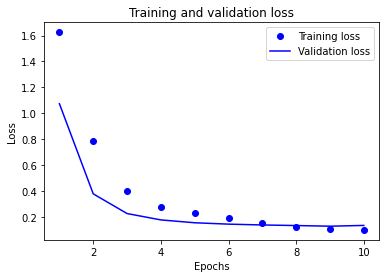

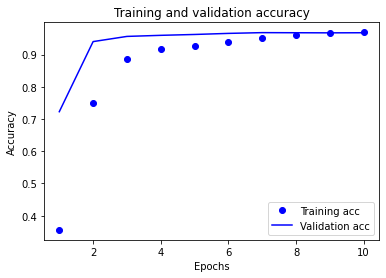

In [ ]:
# plot the graphs
history_dict = history.history # dictionary of result values
epochs = range(1, len(history_dict['accuracy']) + 1) # number of epochs

# plot for loss
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot for accuracy
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Model 2

In [ ]:
# model definition
num_tokens = len(voc) + 2
embedding_dim = 8

model2 = tf.keras.Sequential([
  layers.Embedding(num_tokens, embedding_dim, input_length=sequence_length, name='Embedding_1'),
  layers.GlobalAveragePooling1D(name='GlobalAveragePool_1'),
  layers.Dense(32, activation='relu', name='Dense_1'),
  layers.Dropout(0.2, name='Dropout_1'),
  layers.Dense(7, activation='softmax', name='Dense_2')])

model2._name = 'ModelwithIntEncodingAndGlobalAveragePool'
model2.summary()

Model: "ModelwithIntEncodingAndGlobalAveragePool"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_1 (Embedding)     (None, 65, 8)             75520     
                                                                 
 GlobalAveragePool_1 (Global  (None, 8)                0         
 AveragePooling1D)                                               
                                                                 
 Dense_1 (Dense)             (None, 32)                288       
                                                                 
 Dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 Dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 76,039
Trainable params: 76,039
Non-trainable params: 0
______________________

In [ ]:
# model compiling
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

# model training
epochs = 15
%time history = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)

Epoch 1/15
311/311 [==============================] - 1s 3ms/step - loss: 1.9317 - accuracy: 0.2320 - val_loss: 1.8858 - val_accuracy: 0.3176
Epoch 2/15
311/311 [==============================] - 1s 3ms/step - loss: 1.6593 - accuracy: 0.4563 - val_loss: 1.3904 - val_accuracy: 0.6007
Epoch 3/15
311/311 [==============================] - 1s 3ms/step - loss: 1.2110 - accuracy: 0.6372 - val_loss: 1.0072 - val_accuracy: 0.8375
Epoch 4/15
311/311 [==============================] - 1s 3ms/step - loss: 0.8712 - accuracy: 0.7973 - val_loss: 0.6790 - val_accuracy: 0.9156
Epoch 5/15
311/311 [==============================] - 1s 3ms/step - loss: 0.6066 - accuracy: 0.8629 - val_loss: 0.4791 - val_accuracy: 0.9363
Epoch 6/15
311/311 [==============================] - 1s 3ms/step - loss: 0.4479 - accuracy: 0.9044 - val_loss: 0.3584 - val_accuracy: 0.9407
Epoch 7/15
311/311 [==============================] - 1s 2ms/step - loss: 0.3448 - accuracy: 0.9220 - val_loss: 0.2814 - val_accuracy: 0.9534
Epoch 

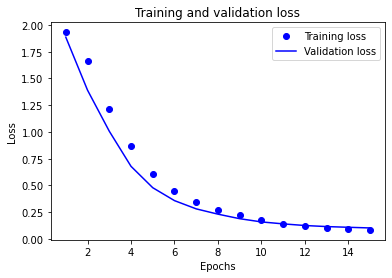

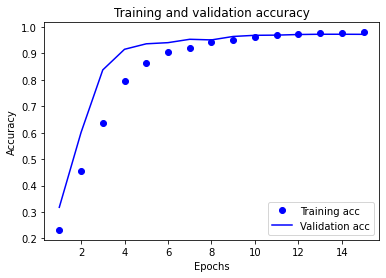

In [ ]:
# plot the graphs
history_dict = history.history # dictionary of result values
epochs = range(1, len(history_dict['accuracy']) + 1) # number of epochs

# plot for loss
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot for accuracy
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

**Evaluate Model**

In [ ]:
# evaluate model on test dataset
x_test = np.array([np.array(val) for val in testdf['text']])
y_test = np.array([np.array(val) for val in testdf['intent']])
# model 1 evaluation
print('Model 1 Evaluation on Test Set:')
loss, accuracy = model1.evaluate(x_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
# model 2 evaluation
print('\nModel 2 Evaluation on Test Set:')
loss, accuracy = model2.evaluate(x_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Model 1 Evaluation on Test Set:
40/40 [==============================] - 0s 2ms/step - loss: 0.1277 - accuracy: 0.9672
Loss:  0.12768003344535828
Accuracy:  0.9671875238418579

Model 2 Evaluation on Test Set:
40/40 [==============================] - 0s 1ms/step - loss: 0.1056 - accuracy: 0.9711
Loss:  0.10557307302951813
Accuracy:  0.9710937738418579


**Export Best Model**

In [ ]:
# save the model
export_model = tf.keras.Sequential([
  tf.keras.Input(shape=(1,), dtype="string"),
  vectorize_layer,
  model2 ]) # saving model 2

export_model.save('saved_model/model2_intencoding', save_format='tf')

**Conclusion:**

**Model 1:**

INPUT => EMBEDDING(int encoding) => FLATTEN => FC => RELU => DO => FC => SOFTMAX
1.   Trainable Parameters: 83,975
1.   Epochs: 10
2.   Loss and Accuracy:
    *   Training Loss: 0.1017 - Training Accuracy: 0.9690
    *   Validation Loss: 0.1363 - Validation Accuracy: 0.9675
    *   Testing Loss: 0.1276 - Testing Accuracy: 0.9671
3.   Wall Time: 9.2s
**Model 2:**

INPUT => EMBEDDING(int encoding) => GAP1D => FC => RELU => DO => FC => SOFTMAX
1.   Trainable Parameters: 76,039
1.   Epochs: 15
2.   Loss and Accuracy:
    *   Training Loss: 0.0437 - Training Accuracy: 0.9885
    *   Validation Loss: 0.1214 - Validation Accuracy: 0.9712
    *   Testing Loss: 0.1055 - Testing Accuracy: 0.9710
3.   Wall Time: 12.9s

**ANALYSIS:**

1.   Model 1's flatten layer leads to more trainable parameters compared to Model 2 that uses GlobalAveragePooling1D.
2.   Better performance is achieved by model 2.